# Drogued VS undrogued + Ekman at surface VS at 15m

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import histlib.matchup as match
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x
from histlib.cstes import labels, zarr_dir, matchup_dir, var, c0, c1
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
DL =25*1e3 #meters
DT = 0.5*3600 #seconds
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x'

id_co_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_drifter_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

In [3]:
def put_fig_letter(ax, letter):
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes+trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

________
# Datasets 

In [4]:
dsd = xr.open_dataset(os.path.join(zarr_dir+'_ok','global', f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
dsud = xr.open_dataset(os.path.join(zarr_dir+'_ok','global', f'ms_{int(DL//1000)}_{DT}_undrogued.zarr'))

dsmeand = xr.open_dataset(os.path.join(zarr_dir+'_ok','global', f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))
dsmeanud = xr.open_dataset(os.path.join(zarr_dir+'_ok','global', f'mean_{int(DL//1000)}_{DT}_undrogued.zarr'))

gps = [l for l in dsd.drifter_sat_year.values if 'gps' in l]
argos = [l for l in dsd.drifter_sat_year.values if 'argos' in l]
dsdg, mslow, msup = global_ms_drifter_sat_year(dsmeand.sel(drifter_sat_year=gps), dsd.sel(drifter_sat_year=gps), alpha=0.01)
mserrdg = (msup-mslow)/2
dsda, mslow, msup = global_ms_drifter_sat_year(dsmeand.sel(drifter_sat_year=argos), dsd.sel(drifter_sat_year=argos), alpha=0.01)
mserrda = (msup-mslow)/2

gps = [l for l in dsud.drifter_sat_year.values if 'gps' in l]
argos = [l for l in dsud.drifter_sat_year.values if 'argos' in l]
dsudg, mslow, msup = global_ms_drifter_sat_year(dsmeanud.sel(drifter_sat_year=gps), dsud.sel(drifter_sat_year=gps), alpha=0.01)
mserrudg = (msup-mslow)/2
dsuda, mslow, msup = global_ms_drifter_sat_year(dsmeanud.sel(drifter_sat_year=argos), dsud.sel(drifter_sat_year=argos), alpha=0.01)
mserruda = (msup-mslow)/2



<xarray.DataArray 'nb_coloc' ()>
array(146030)
<xarray.DataArray 'nb_coloc' ()>
array(91830)
<xarray.DataArray 'nb_coloc' ()>
array(159148)
<xarray.DataArray 'nb_coloc' ()>
array(161561)


______________________
# Drogued VS undrogued 
## Residual

In [5]:
def compute_sum_ms(ds, id_):
    dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
def RSE_id(ds, id_):
    dic = ds['sum_'+id_].attrs
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']
    return (ds['sum_'+id_]/(ds[acc]+ds[cor]+ds[ggrad]+ds[wd])).values*100

In [6]:
print('Along-track -GPS : drogued')
print('S2 = ' + f"{dsdg['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsdg, id_co)}")
print('Along-track -GPS: undrogued')
print('S2 = ' + f"{dsudg['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsudg, id_co)}")


Along-track -GPS : drogued
S2 = 1.5534432205925074e-10
RSE = 19.388954794635538
Along-track -GPS: undrogued
S2 = 2.4159630812209996e-10
RSE = 25.9815348366364


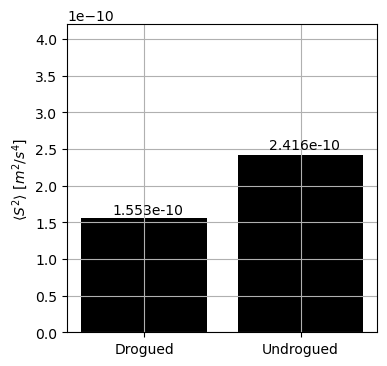

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4), frameon=False)

ax.bar(0.5, dsdg['sum_'+id_co], color ='k',width = 0.4)
ax.bar(1, dsudg['sum_'+id_co], color ='k',width = 0.4)
ax.text(0.4, dsdg['sum_'+id_co]+dsdg['sum_'+id_co]/30, str(np.format_float_scientific(dsdg['sum_'+id_co].values,precision = 3)))
ax.text(0.9, dsudg['sum_'+id_co]+dsudg['sum_'+id_co]/30, str(np.format_float_scientific(dsudg['sum_'+id_co].values,precision = 3)))

ax.grid()
ax.set_ylim(0,4.2e-10)
ticks = ('Drogued', 'Undrogued')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$\langle S^2 \rangle$ $[m^2/s^4]$')
fig.savefig('../images_all/drogue_undrogue_msre.png', bbox_inches='tight',   dpi=300)

Text(0, 0.5, '$RSE$ [%]')

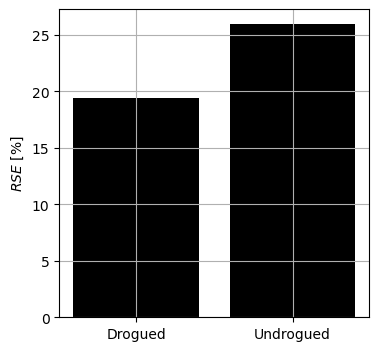

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, RSE_id(dsdg, id_co), color ='k',width = 0.4)
ax.bar(1, RSE_id(dsudg, id_co), color ='k',width = 0.4)

ax.grid()

ticks = ('Drogued', 'Undrogued')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$RSE$ [%]')

In [9]:
def compute_sum_ms(ds, id_):
    dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
def RC_x(ds, id_):
    if isinstance(id_, str):
        dic = ds['sum_'+id_].attrs
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        s = compute_sum_ms(ds, id_)
        df = pd.DataFrame({l:((ds['exc_'+l+'_'+id_] - ds['sum_'+id_])/s).values for l in lab}, index=pd.Index([id_], name='id_comb'))
    else :
        D =[]
        DN = []
        for id__ in id_ :
            dic = ds['sum_'+id__].attrs
            lab = ['acc', 'coriolis', 'ggrad', 'wind']
            s = compute_sum_ms(ds, id__)
            D.append(pd.DataFrame({l:((ds['exc_'+l+'_'+id__] - ds['sum_'+id__])).values for l in lab}, index=pd.Index([id__], name='id_comb')))
            DN.append(pd.DataFrame({l:((ds['exc_'+l+'_'+id__] - ds['sum_'+id__])/s).values for l in lab}, index=pd.Index([id__], name='id_comb')))
        df=pd.concat(D)
        dfn=pd.concat(DN)
    return df, dfn

________________________
# True/Error in $x$ 

In [10]:
def true_err_x(ds, id_) :
    dso = xr.Dataset()
    dic = ds['sum_'+id_].attrs
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds[X]
        dso['exc_'+x] = ds['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds[X] - ds['sum_'+id_] + ds['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds[X] + ds['sum_'+id_] - ds['exc_' + x +'_'+ id_])/2
    dso['S'] = ds['sum_'+id_]
    return dso
dsmsug = xr.concat([true_err_x(dsudg, id_co), true_err_x(dsudg, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))
dsmsg = xr.concat([true_err_x(dsdg, id_co), true_err_x(dsdg, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

In [11]:
def plot_cor_uncor_part(ds, ax, title=None):
    """ 
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    # ACC X
    ax.bar(1.5, ds['true_acc'],
           color = c0['acc'], width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds['err_acc'], bottom = ds['true_acc'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(1.5, ds['acc']+5e-12, str(np.format_float_scientific(ds['acc'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_acc']/ds['acc']*100,2)
    ax.text(1.5, ds['true_acc']+5e-12, f'{rse.values}%', horizontalalignment='center')

    # CORIOLIS
    ax.bar(2, ds['true_coriolis'],
           color = c0['coriolis'], width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds['err_coriolis'], bottom = ds['true_coriolis'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(2, ds['coriolis']+5e-12, str(np.format_float_scientific(ds['coriolis'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_coriolis']/ds['coriolis']*100,2)
    ax.text(2, ds['true_coriolis']+5e-12, f'{rse.values}%', horizontalalignment='center')
    """
    # G GRADIENT SLA
    ax.bar(2.5, ds['true_ggrad'],
           color = c0['ggrad'], width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds['err_ggrad'], bottom = ds['true_ggrad'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(2.5, ds['ggrad']+5e-12, str(np.format_float_scientific(ds['ggrad'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_ggrad']/ds['ggrad']*100,2)
    ax.text(2.5, ds['true_ggrad']+5e-12, f'{rse.values}%', horizontalalignment='center')

        # WIND
    ax.bar(3, ds['true_wind'],
           color = c0['wind'], width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds['err_wind'], bottom = ds['true_wind'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(3, ds['wind']+4e-11, str(np.format_float_scientific(ds['wind'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_wind']/ds['wind']*100,2)
    ax.text(3, ds['true_wind']+5e-12, f'{rse.values}%', horizontalalignment='center')
    """
    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)

    if isinstance(title, int): ax.set_title(ds.id_comb)
    else : ax.set_title(title+'\n')
    
    #N=np.arange(1.5,3.5, 0.5) 
    N = [1.5,2]
    ticks = (r'$d_tu$', r'$-fv$')#, r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks(N, ticks,)

In [12]:
def plot_cor_uncor_part(ds1, ds2, ax, title=None):
    """ 
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    ds=ds1
    # ACC X
    ax.bar(1.5, ds['true_acc'],
           color = c0['acc'], width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds['err_acc'], bottom = ds['true_acc'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(1.5, ds['acc']+18e-12, str(np.format_float_scientific(ds['acc'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_acc']/ds['acc']*100,2)
    ax.text(1.5, ds['true_acc']+7e-12, f'{rse.values}%', horizontalalignment='center')

    # CORIOLIS
    ax.bar(2, ds['true_coriolis'],
           color = c0['coriolis'], width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds['err_coriolis'], bottom = ds['true_coriolis'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(2, ds['coriolis']+9e-12, str(np.format_float_scientific(ds['coriolis'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_coriolis']/ds['coriolis']*100,2)
    ax.text(2, ds['true_coriolis']+7e-12, f'{rse.values}%', horizontalalignment='center')

    ds=ds2
    # ACC X
    ax.bar(2.5, ds['true_acc'],
           color = c0['acc'], width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds['err_acc'], bottom = ds['true_acc'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(2.5, ds['acc']+18e-12, str(np.format_float_scientific(ds['acc'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_acc']/ds['acc']*100,2)
    ax.text(2.5, ds['true_acc']+7e-12, f'{rse.values}%', horizontalalignment='center')

    # CORIOLIS
    ax.bar(3, ds['true_coriolis'],
           color = c0['coriolis'], width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds['err_coriolis'], bottom = ds['true_coriolis'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(3, ds['coriolis']+9e-12, str(np.format_float_scientific(ds['coriolis'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_coriolis']/ds['coriolis']*100,2)
    ax.text(3, ds['true_coriolis']+7e-12, f'{rse.values}%', horizontalalignment='center')

    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)

    if isinstance(title, int): ax.set_title(ds.id_comb)
    else : ax.set_title(title)
    N = [1.5, 2, 2.5, 3]
    #N=np.arange(1.5,3.5, 0.5) 
    ticks = (r'$d_tu$', r'$-fv$', r'$d_tu$', r'$-fv$')#, r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks(N, ticks,)

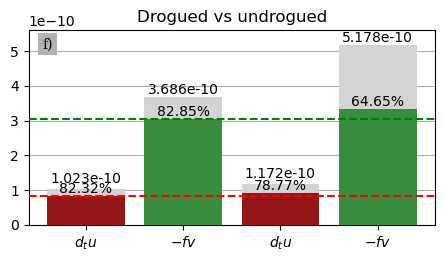

In [28]:
plt.rcParams["axes.edgecolor"] = "k"
fig_title=1
fig, ax = plt.subplots(nrows=1,ncols=1,
                            sharey='all',
                            figsize=(4.55,3.4), frameon=False)
plot_cor_uncor_part(dsmsg.sel(id_comb=id_co),dsmsug.sel(id_comb=id_co), ax=ax, title ='Drogued vs undrogued')
ax.axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
ax.axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)

put_fig_letter(ax, 'f')

ax.set_ylim(0, 5.6e-10)
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.savefig('../images_all/drogue_undrogue_true_err.png', bbox_inches='tight',   dpi=300)

In [32]:
dsmsg.sel(id_comb=id_co)['err_coriolis']-dsmsug.sel(id_comb=id_co)['err_coriolis']

<xarray.DataArray 'err_coriolis' ()>
array(-1.1984644e-10)
Coordinates:
    id_comb  <U71 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z...

In [15]:
import itertools
from histlib.diagnosis import global_drifter_sat, error_on_covariances
corr_key_co = list(itertools.combinations(list(id_co_dic.values()),2))
corr_key_av = list(itertools.combinations(list(id_aviso_dic.values()),2)) 
corr_var_co = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_co]
corr_var_aviso = ["prod_"+ab[0]+"__"+ab[1] for ab in corr_key_av]

dsc = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'corr_{int(DL//1000)}_{DT}_drogued.zarr'))[corr_var_co+['nb_coloc']]
gps = [l for l in dsc.drifter_sat_year.values if 'gps' in l]
dsdgcor_co = global_drifter_sat(dsc.sel(drifter_sat_year=gps))
dsdgcor_co_err = error_on_covariances(dsdgcor_co, dsdg , corr_key_co, alpha=0.0001)

dsudgcor_co = global_drifter_sat(dsc.sel(drifter_sat_year=gps))
dsudgcor_co_err = error_on_covariances(dsudgcor_co, dsudg , corr_key_co, alpha=0.0001)



<xarray.DataArray 'nb_coloc' ()>
array(146030)
<xarray.DataArray 'nb_coloc' ()>
array(146030)


In [16]:
dsmsdg = true_err_x(dsdg,id_co)
dsmsudg = true_err_x(dsudg,id_co)

In [17]:
def synthetic_figure(ds, dsc, dic, ax, xlim=None) :
    plt.rcParams["axes.edgecolor"] = "w"
    a=1.5
    bbox = dict(facecolor='w', alpha=0.8, edgecolor='w')
    def vn(id_dic, key1, key2):
        return 'prod_'+id_dic[key1]+'__'+id_dic[key2]
    
    ts = ds['acc']+ds['coriolis']+ds['ggrad']+ds['wind']
    print(ts)
    #gap between bars for readability
    if xlim : b=xlim/400
    else : b=ts/400
    
    ## INDIVIDUAL MS ##
    ax.barh(2*a, ds['acc'], color= c0['acc'], label = 'Inertial acceleration')
    ax.barh(2*a, ds['coriolis'], left =ds['acc']+b , color= c0['coriolis'], label = 'Coriolis acceleration')
    ax.barh(2*a, ds['ggrad'], left =ds['acc']+ds['coriolis']+2*b , color= c0['ggrad'], label = 'Pressure gradient term')
    ax.barh(2*a, ds['wind'], left =ds['acc']+ds['coriolis']+ds['ggrad']+3*b, color= c0['wind'], label = 'Wind term')
    

    ax.text(ts/2, 2*a+0.5, r'Individual MS $A_i$', ha='center') 
    #percentage + MS
    key = ['acc', 'coriolis', 'ggrad', 'wind']
    for i in range(len(key)) :
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 2*a, f'{int(np.rint((ds[key[i]]/ts).values*100))} %', ha='center',bbox=bbox )
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b, 2*a-0.55, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
    
    #accolade
    c = 1e-12
    id1 =0
    id2 = ts + 3*b
    bx = [id1, id1, id2, id2]
    by = [3.70, 3.75, 3.75, 3.70]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(ts, 3.8, r'$\Sigma$', fontsize=15, ha='center')
    
    ## CAPTURED PHYSICAL + ERRORS PARTS ##
    ax.barh(1*a, ds['true_acc'], color= c0['acc'])
    ax.barh(1*a, ds['err_acc'], left = ds['true_acc'], color= 'lightgrey', label='Errors')
    ax.barh(1*a, ds['true_coriolis'], left =ds['true_acc']+ds['err_acc']+b, color= c0['coriolis'])
    ax.barh(1*a, ds['err_coriolis'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis'], color= 'lightgrey')
    ax.barh(1*a, ds['true_ggrad'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+b, color= c0['ggrad'])
    if ds['err_ggrad']>0 : 
        ax.barh(1*a, ds['err_ggrad'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad'], color= 'lightgrey')
        ax.barh(1*a, ds['true_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['err_ggrad']+b, color= c0['wind'])
        ax.barh(1*a, ds['err_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['err_ggrad']+ds['true_wind'], color= 'lightgrey')
    else : 
        print('ok')
        ax.barh(1*a, ds['true_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+2*b, color= c0['wind'])
        ax.barh(1*a, ds['err_wind'], left =ds['true_acc']+ds['err_acc']+ ds['true_coriolis']+ ds['err_coriolis']+ds['true_ggrad']+ds['true_wind']+2*b, color= 'lightgrey')
    
    ax.text(ts/2, 1*a+0.5, r'Balanced physical and errors parts MS $B_i$ and $E_i$', ha='center') 
    #percentage + MS
    key = ['true_acc','err_acc', 'true_coriolis','err_coriolis', 'true_ggrad','err_ggrad', 'true_wind', 'err_wind']
    for i in range(len(key)) :
        d=0
        dx=0
        if i==len(key)-1 : 
            d=-0.1*a 
            dx = 3e-11
        if i==len(key)-2 : d=0.1*a 
        if 'aviso' in dic['ggrad'] and i==len(key)-3 : d=-0.1*a
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b/2, a+d, f'{int(np.rint((ds[key[i]]/ts).values*100))} %', ha='center', bbox=bbox)
        d=0        
        if i%2 ==1 : d=-0.1*a
        ax.text(sum([ds[v] for v in key[:i]])+ds[key[i]]/2+i*b/2+dx, a+d -0.55, f'{np.format_float_scientific(ds[key[i]].values,precision = 1)}', ha='center')
        
    ## PAIRS + RESIDUAL ##
    plt.rcParams['hatch.linewidth'] = 10
    plt.rcParams['hatch.color'] = c0['ggrad']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'ggrad')], color=c0['coriolis'], hatch='/')
    plt.rcParams['hatch.color'] = c0['coriolis']
    ax.barh(0, dsc[vn(dic, 'acc', 'coriolis')], color=c0['acc'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+b)
    plt.rcParams['hatch.color'] = c0['acc']
    ax.barh(0, dsc[vn(dic, 'acc', 'ggrad')], color=c0['ggrad'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+2*b)
    plt.rcParams['hatch.color'] = c0['wind']
    ax.barh(0, dsc[vn(dic, 'coriolis', 'wind')], color=c0['coriolis'], hatch='/', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+3*b)
    ax.barh(0, ds['S'], color='lightgrey', left = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b)

    tts = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+4*b+ds['S']
    print(tts)
    sum_pairs = dsc[vn(dic, 'coriolis', 'ggrad')]+dsc[vn(dic, 'acc', 'coriolis')]+dsc[vn(dic, 'acc', 'ggrad')]+dsc[vn(dic, 'coriolis', 'wind')]+3*b
    ax.text(sum_pairs/2, 0.6, r"Pairs' contributions $X_{ij}$", ha='center')
    #accolade
    c = 1e-12
    id1 =0
    id2 = sum_pairs
    bx = [id1, id1, id2, id2]
    by = [0.45, 0.5, 0.5, 0.45]
    ax.plot(bx, by, 'k-', lw=2)
    ax.text(sum_pairs + ds['S']/2, 0.5, r'$S$', ha='center')

    #percentage + MS
    key = [vn(dic, 'coriolis', 'ggrad'),vn(dic, 'acc', 'coriolis'), vn(dic, 'acc', 'ggrad'), vn(dic, 'coriolis', 'wind')]
    for i in range(len(key)) :
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0, f'{int(np.rint((dsc[key[i]]/ts).values*100))} %', ha='center', bbox=bbox)
        d=0
        if 'aviso' in dic['ggrad'] and key[i]== vn(dic, 'acc', 'ggrad') : d = -0.1*a
        ax.text(sum([dsc[v] for v in key[:i]])+dsc[key[i]]/2+i*b, 0-0.55+d, f'{np.format_float_scientific(dsc[key[i]].values,precision = 1)}', ha='center')
    
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0, f'{int(np.rint((ds["S"]/ts).values*100))} %', ha='center', bbox=bbox)
    ax.text(sum([dsc[v] for v in key])+ds['S']/2+i*b, 0-0.55, f'{np.format_float_scientific(ds["S"].values,precision = 1)}', ha='center')

    # FIGURE SET
    ax.set_yticks([])
    if not xlim : xlim=tts
    ax.set_xlim(-1e-11, xlim+1e-11)
    ax.set_ylim(-1, 4.1)
    ax.get_yaxis().set_visible(False)
    ax.annotate('',xy=(xlim,-1),xytext=(0,-1),arrowprops={'arrowstyle':'->', 'facecolor':'k'})
    ax.set_xlabel(r'$[m^2.s^{-4}]$')
    

<xarray.DataArray ()>
array(8.01200084e-10)
<xarray.DataArray ()>
array(8.23970302e-10)


Text(0.5, 0.98, 'Argos')

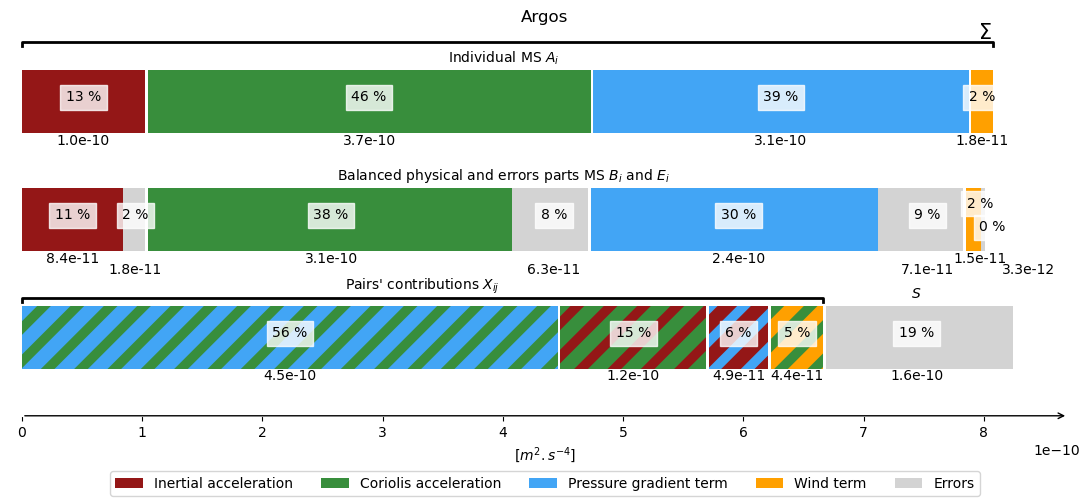

In [18]:
plt.rcParams["axes.edgecolor"] = "w"
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False, )

synthetic_figure(dsmsdg, -2*dsdgcor_co, id_co_dic, ax, xlim=8.7e-10) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('Argos')
#fig.savefig('images/synth_alg_argos_cutoff25.png',bbox_inches='tight',   dpi=300)

<xarray.DataArray ()>
array(9.29876967e-10)
<xarray.DataArray ()>
array(9.11522288e-10)


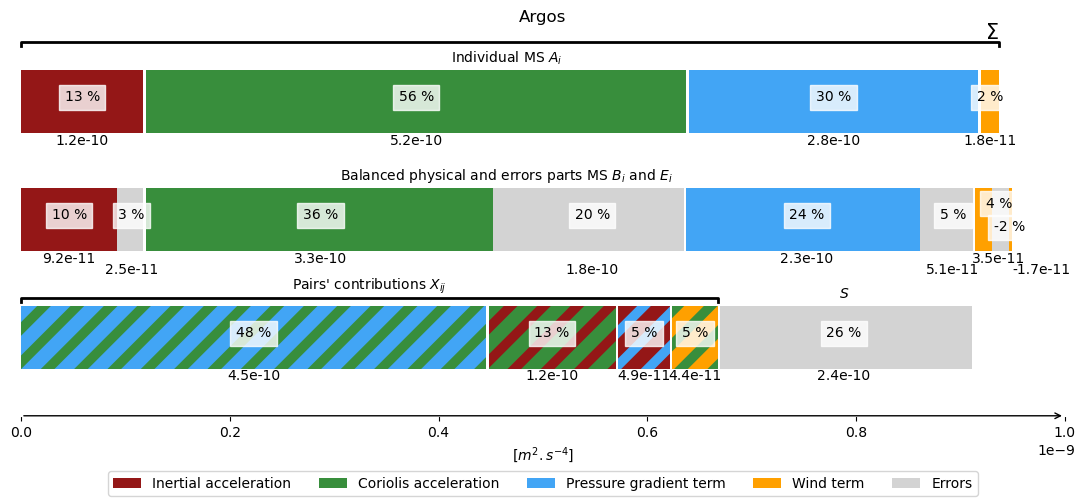

In [19]:
plt.rcParams["axes.edgecolor"] = "w"
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(11,5), frameon=False, )

synthetic_figure(dsmsudg, -2*dsdgcor_co, id_co_dic, ax, xlim=1e-9) 
fig.legend(ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.04,1,1])#left, bottom, right, top (default is 0,0,1,1)
fig.suptitle('Argos')
fig.savefig('images/synth_undrogue_gps_alg_cutoff25.png',bbox_inches='tight',   dpi=300)

______________________
# Drogued 0 vS 15m  
Open in 'global_'
## Residual

In [31]:
[ v for v in dsdg.variables if 'sum' in v]

['sum_aviso__01__adt__es_cstrio_z15__alti_x',
 'sum_aviso__01__adt__es_cstrio_z15__drifter_x',
 'sum_aviso__02__adt__es_cstrio_z15__alti_x',
 'sum_aviso__02__adt__es_cstrio_z15__drifter_x',
 'sum_aviso__05__adt__es_cstrio_z15__alti_x',
 'sum_aviso__05__adt__es_cstrio_z15__drifter_x',
 'sum_aviso__0__adt__es_cstrio_z15__alti_x',
 'sum_aviso__0__adt__es_cstrio_z15__drifter_x',
 'sum_aviso__15__adt__es_cstrio_z15__alti_x',
 'sum_aviso__15__adt__es_cstrio_z15__drifter_x',
 'sum_aviso__1__adt__es_cstrio_z15__alti_x',
 'sum_aviso__1__adt__es_cstrio_z15__drifter_x',
 'sum_aviso__25__adt__es_cstrio_z15__alti_x',
 'sum_aviso__25__adt__es_cstrio_z15__drifter_x',
 'sum_aviso__2__adt__es_cstrio_z15__alti_x',
 'sum_aviso__2__adt__es_cstrio_z15__drifter_x',
 'sum_co__01__adt_filtered__es_cstrio_z15__alti_x',
 'sum_co__01__adt_filtered__es_cstrio_z15__drifter_x',
 'sum_co__01__adt_filtered_ocean_tide__es_cstrio_z15__alti_x',
 'sum_co__01__adt_filtered_ocean_tide__es_cstrio_z15__drifter_x',
 'sum_co__

In [15]:
id_co0 = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z0__drifter_x'
print('Along-track -GPS-drogued : 15m')
print('S2 = ' + f"{dsdg['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsdg, id_co)}")
print('Along-track -GPS-drogued : 0m')
print('S2 = ' + f"{dsdg['sum_'+id_co0].values}")
print(f"RSE = {RSE_id(dsdg, id_co0)}")


Along-track -GPS-drogued : 15m
S2 = 1.5534432205925074e-10
RSE = 19.388954794635538
Along-track -GPS-drogued : 0m


KeyError: 'sum_co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z0__drifter_x'

In [ ]:
id_co0 = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z0__drifter_x'

In [ ]:

dsmsg = xr.concat([true_err_x(dsdg, id_co), true_err_x(dsdg, id_co0)], dim=pd.Index([id_co, id_co0], name = 'id_comb'))

In [ ]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(9,6))
plot_cor_uncor_part(dsmsdg.sel(id_comb=id_co), ax=axs[0], title ='15m')
plot_cor_uncor_part(dsmsdg.sel(id_comb=id_co0), ax=axs[1], title ='Surface')
axs[0].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[1].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[0].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)
axs[1].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)

put_fig_letter(axs[0], 'a')
put_fig_letter(axs[1], 'b')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

______________________
# Undrogued 0 vS 15m
## Residual

In [25]:
print('Along-track -GPS-drogued : 15m')
print('S2 = ' + f"{dsg['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsg, id_co)}")
print('Along-track -GPS-drogued : 0m')
print('S2 = ' + f"{dsg['sum_'+id_co0].values}")
print(f"RSE = {RSE_id(dsg, id_co0)}")


Along-track -GPS-drogued : 15m
S2 = 1.5534432205925074e-10
RSE = 19.388954794635538
Along-track -GPS-drogued : 0m
S2 = 3.540895998198724e-10
RSE = 39.42237183042705


In [24]:
print('Along-track -GPS-undrogued : 15m')
print('S2 = ' + f"{dsug['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsug, id_co)}")
print('Along-track -GPS-undrogued : 0m')
print('S2 = ' + f"{dsug['sum_'+id_co0].values}")
print(f"RSE = {RSE_id(dsug, id_co0)}")


Along-track -GPS-undrogued : 15m
S2 = 2.4159630812209996e-10
RSE = 25.9815348366364
Along-track -GPS-undrogued : 0m
S2 = 6.039571167844001e-10
RSE = 58.8375744835647


In [19]:

dsmsg = xr.concat([true_err_x(dsug, id_co), true_err_x(dsug, id_co0)], dim=pd.Index([id_co, id_co0], name = 'id_comb'))

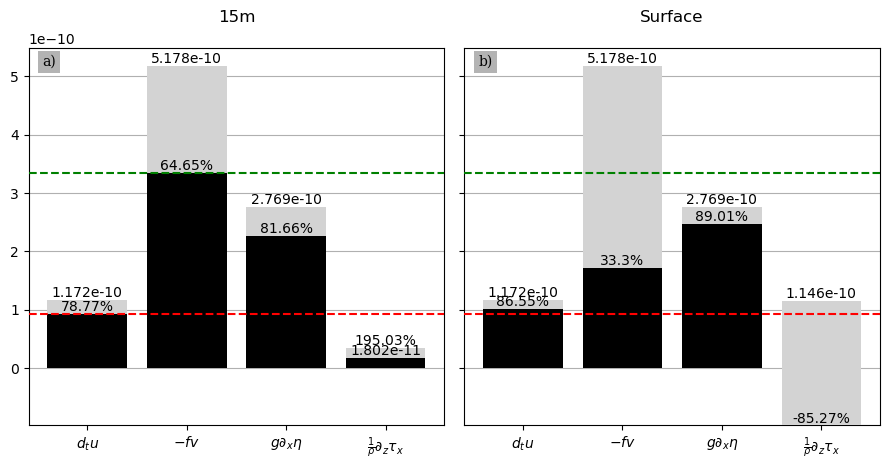

In [20]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(9,6))
plot_cor_uncor_part(dsmsg.sel(id_comb=id_co), ax=axs[0], title ='15m')
plot_cor_uncor_part(dsmsg.sel(id_comb=id_co0), ax=axs[1], title ='Surface')
axs[0].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[1].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[0].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)
axs[1].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)

put_fig_letter(axs[0], 'a')
put_fig_letter(axs[1], 'b')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)